In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import math 

from scipy import optimize

In [2]:
def PolyModel(x, a, b, c):
	return a + (b*x) + (c*x*x)

def LinModel(x, m, c):
	return (m*x)+c

In [6]:
test_temp = 25

#print(sys.argv)

my_data1 = np.genfromtxt("test.csv", delimiter=',') # Temp dep M and C constants 
log_data = np.genfromtxt("test2.csv", delimiter=',') # Test Data

ehum = log_data[0:,1] #E+E Hum,
etemp = log_data[0:,2] #E+E Temp,
vhum = log_data[0:,3] #Vaisala Hum,
vtemp = log_data[0:,4] #Vaisala Temp,
shum = log_data[0:,5] #SGS Hum,
stemp = log_data[0:,6] #SGS Temp,
sraw = log_data[0:,7] #SGS RAW,
scalc = log_data[0:,8] #SGS Calc,
shum2 = log_data[0:,9] #SGS 2 Hum,
stemp2 = log_data[0:,10] #SGS 2 Temp,
sraw2 = log_data[0:,11] #SGS 2 RAW,
scalc2 = log_data[0:,12] #SGS 2 Calc

indep_data = my_data1[0:,2]
dep_data = my_data1[0:,0]

[-1.57334417e+02  5.40256091e+05]


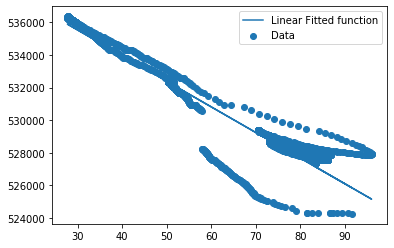

In [12]:
paramsLin, params_covarianceLin = optimize.curve_fit(LinModel, vhum, sraw2)

print(paramsLin)

plt.figure(figsize=(6, 4))

plt.scatter(vhum, sraw2, label='Data')
plt.plot(vhum, LinModel(vhum, paramsLin[0], paramsLin[1]),label='Linear Fitted function')

plt.legend(loc='best')
plt.show()

[ -1.06521938 -34.69982342]
[-2.48226197e+01 -2.12503197e+00  2.18988067e-02]


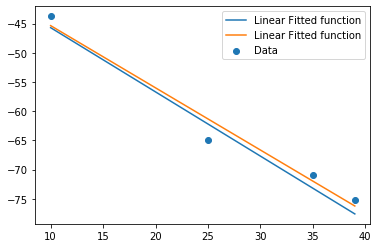

In [10]:
paramsLin, params_covarianceLin = optimize.curve_fit(LinModel, indep_data, dep_data)
paramsPoly, params_covariancePoly = optimize.curve_fit(PolyModel, indep_data, dep_data)

print(paramsLin)
print(paramsPoly)

plt.figure(figsize=(6, 4))
plt.scatter(indep_data, dep_data, label='Data')

plt.plot(indep_data, LinModel(indep_data, -1.1, paramsLin[1]),label='Linear Fitted function')
plt.plot(indep_data, LinModel(indep_data, paramsLin[0], paramsLin[1]),label='Linear Fitted function')

plt.legend(loc='best')

plt.show()